### Moduļi

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_bloch_vector
from scipy.linalg import expm, logm, polar

### Konstantes

In [2]:
# Aproksimācijas precizitāte
EPSILON = 1e-4

# Izmantojamo vārtu kopa
GATESET = {}

tempqc = QuantumCircuit(1)
tempqc.t(0)
GATESET[' T'] = tempqc
tempqc = tempqc.copy().inverse()
GATESET['-T'] = tempqc
del tempqc

tempqc = QuantumCircuit(1)
tempqc.h(0)
GATESET[' H'] = tempqc
del tempqc

# Pauli matricas 
I = np.eye(2, dtype=complex)
X = np.array([[0, 1], [1, 0]], complex)
Y = np.array([[0, -1j], [1j, 0]], complex)
Z = np.array([[1, 0], [0, -1]], complex)
PAULI_BASE = [X, Y, Z]

In [14]:
# Pārbauda, vai divas Rz vārti dod pareizo rezultātu
tempqc = QuantumCircuit(1)
tempqc.h(0)
tempqc.p(np.pi / 4, 0)
tempqc.p(np.pi / 4, 0)
print(Operator(tempqc).data)
print(tempqc.name)
del tempqc

# Izdrukā vārtu kopu
for gate_name in GATESET:
    print("Gate:", gate_name)
    print(Operator(GATESET[gate_name]).data)

[[0.70710678+0.j         0.70710678+0.j        ]
 [0.        +0.70710678j 0.        -0.70710678j]]
circuit-143
Gate:  T
[[1.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.70710678+0.70710678j]]
Gate: -T
[[1.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.70710678-0.70710678j]]
Gate:  H
[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]


### Saglabātās īsās ķēdes

In [25]:
# Īsas ķēdes ātrai piekļuvei aproksimācijai
SHORTHAND = []
SHORTHAND_LEN = 12
shorthand_levels = [[] for (_) in range(SHORTHAND_LEN)]

# Sāk ar īsajām ķēdēm ar vienu vārtu
for (gate_name, gate_qc) in GATESET.items():
    gate_U = Operator(gate_qc).data
    shorthand_levels[0].append((gate_name, gate_qc, gate_U))

# Visas iespējamās kombinācijas līdz SHORTHAND_LEN vārtiem
for (i) in range(1, SHORTHAND_LEN):
    for (name, qc, _) in shorthand_levels[i-1].copy():
        for (gate_name, gate_qc) in GATESET.items():
            if (name[-2:] == gate_name == ' H'): # Izvairās no diviem H pēc kārtas (jo H*H=I)
                continue
            if (name[-1] == gate_name[1]) and (name[-2] == '-' or gate_name[0] == '-'): # Izvairās no diviem vienādiem Rz pēc kārtas
                continue
            if (gate_name == name[-2:] == name[-5:-3] == name[-8:-6] == name[-11:-9]): # Izvairās no vairāk kā četrām rotācijām pēc kārtas
                continue
            new_name = name + ' ' + gate_name
            new_qc = qc.copy()
            new_qc.compose(gate_qc, [0], inplace=True)
            new_U = Operator(new_qc).data
            shorthand_levels[i].append((new_name, new_qc, new_U))
    print(f"Pievienoja {len(shorthand_levels[i])} ķēdes garumā {i+1}")

for (i) in range(SHORTHAND_LEN):
    SHORTHAND.extend(shorthand_levels[i])

Pievienoja 5 ķēdes garumā 2
Pievienoja 9 ķēdes garumā 3
Pievienoja 16 ķēdes garumā 4
Pievienoja 28 ķēdes garumā 5
Pievienoja 49 ķēdes garumā 6
Pievienoja 86 ķēdes garumā 7
Pievienoja 151 ķēdes garumā 8
Pievienoja 265 ķēdes garumā 9
Pievienoja 465 ķēdes garumā 10
Pievienoja 816 ķēdes garumā 11
Pievienoja 1432 ķēdes garumā 12


### Funkcijas

In [26]:
# U = expm(i alpha) Rz(beta) H Rz(gamma) H Rz(delta)
def rotation_decomposition(U):

    _, alpha = remove_global_phase(U)

    gamma = 2 * np.arccos(abs(U[0, 0]))

    main_d = np.angle(U[1, 1]) - np.angle(U[0, 0])
    off_d = np.angle(U[1, 0]) - np.angle(U[0, 1])
    beta = (main_d + off_d) / 2
    delta = (main_d - off_d) / 2

    print(alpha, beta, gamma, delta)

    qc = QuantumCircuit(1)
    qc.rz(delta, 0)
    qc.h(0)
    qc.rz(gamma, 0)
    qc.h(0)
    qc.rz(beta, 0)

    return qc, alpha


# Rekursīvais algoritms, kas balstās uz Soloveja-Kitājeva teorēmas
def solovay_kitaev_decomposition(U_target, depth):

    if (depth == 0):
        return shorthand_approximation(U_target)
    
    qc_approx = solovay_kitaev_decomposition(U_target, depth-1)

    if (compare_su2(U_target, Operator(qc_approx).data) < EPSILON):
        return qc_approx

    U_approx = Operator(qc_approx).data
    A, B = gc_decomposition(U_target @ U_approx.conj().T)

    qc_A = solovay_kitaev_decomposition(A, depth-1)
    qc_B = solovay_kitaev_decomposition(B, depth-1)
    qc_A_inv = qc_A.inverse()
    qc_B_inv = qc_B.inverse()

    # Izveido jaunu ķēdi
    qc = QuantumCircuit(1)
    qc.compose(qc_approx, [0], inplace=True)
    qc.compose(qc_B_inv, [0], inplace=True)
    qc.compose(qc_A_inv, [0], inplace=True)
    qc.compose(qc_B, [0], inplace=True)
    qc.compose(qc_A, [0], inplace=True)

    return qc

# Funkcija, kas atrod labāko īso ķēdi dotajam operatoram
# izmanto rekursijas bāzes gadījumā
def shorthand_approximation(U_target):
    print("Ātrais tuvinājums operatoram:")
    print(U_target)

    min_error = float('inf')
    best_entry = SHORTHAND[0]
    for (entry) in SHORTHAND:
        error = compare_su2(U_target, entry[2])
        if (error < min_error):
            min_error = error
            best_entry = entry
    print(f"Tuvākā ķēde {best_entry[0]} ar kļūdu {min_error}")

    return best_entry[1] # atgriež QuantumCircuit

# Grupas komutatora dekompozīcija
def gc_decomposition(U):

    # Noņem globālo fāzi
    U, _ = remove_global_phase(U)

    # Izvelk rotācijas asi un leņķi
    U_xs, U_th = extract_axis_angle(U)

    # Versija 2: formula no pētījuma
    phi = 2 * np.arcsin(((1 - np.cos(U_th / 2)) / 2) ** 0.25)

    X_xs = np.array([1, 0, 0])
    Y_xs = np.array([0, 1, 0])

    # U = S(VWV⁺W⁺)S⁺
    V = rotation_matrix(X_xs, phi)
    W = rotation_matrix(Y_xs, phi)
    Com = V @ W @ V.conj().T @ W.conj().T

    # Atrisina vienādojumu S * commutator * S⁺ = U
    K = np.kron(I, Com.T) - np.kron(U, I)
    _, _, Vh = np.linalg.svd(K)
    S_vec = Vh.conj().T[:, -1]
    S_raw = S_vec.reshape((2, 2))

    S, _ = polar(S_raw)
    S, _ = remove_global_phase(S)

    # Pārbauda dekompozīciju
    print("Pārbaude S * Com * S⁺:")
    print(S @ Com @ S.conj().T)

    A = S @ V @ S.conj().T
    B = S @ W @ S.conj().T

    # Tests
    U_reconstructed = A @ B @ A.conj().T @ B.conj().T
    print("Kļūda:")
    print("      ", compare_su2(U, U_reconstructed))
    print("---\n")
    
    return (A, B)

# Funkcija izvelk rotācijas asi un leņķi no unitāra operatora
def extract_axis_angle(R):
    # Konvertē uz SU(2)
    if not np.isclose(np.linalg.det(R), 1, atol=1e-10):
        raise ValueError("Operators nav SU(2) grupa.")

    # Aprēķina leņķi
    trace = np.trace(R)
    theta = np.arccos(np.real(trace) / 2) * 2

    # Ja leņķis ir tuvu nullei, atgriež standarta asi un nulles leņķi
    if np.isclose(theta, 0, atol=1e-12):
        return np.array([1, 0, 0]), 0

    # Aprēķina rotācijas asi
    A = (R - np.cos(theta / 2) * I) / (-1j * np.sin(theta / 2))
    nx = np.real(A[1, 0])
    ny = np.imag(A[1, 0])
    nz = np.real(A[0, 0])
    axis = np.array([nx, ny, nz]) / np.linalg.norm([nx, ny, nz])

    return (axis, theta)

# Funkcija izveido rotācijas matricas no ass un leņķa
def rotation_matrix(axis, theta):
    return expm(-1j * theta / 2 * (axis[0] * X + axis[1] * Y + axis[2] * Z))

# Funkcija noņem globālo fāzi no unitāra operatora
def remove_global_phase(U):
    phase = np.angle(np.linalg.det(U)) / 2
    V = U / np.exp(1j * phase)
    W, _ = polar(V)
    return W, phase

def add_global_phase(U, phase):
    return U * np.exp(1j * phase)

# Funkcija salīdzina divas matricas bez globālās fāzes
def compare_su2(U1, U2):
    U1, _ = remove_global_phase(U1)
    U2, _ = remove_global_phase(U2)
    return np.linalg.norm(U1 - U2, 2)


def approximate_depth(U, target_error):

    U, _ = remove_global_phase(U)

    qc_approx = shorthand_approximation(U)
    U_approx = Operator(qc_approx).data

    error = compare_su2(U, U_approx)
    c_approx = 4 * np.sqrt(2)

    if error < 1 / 32:
        n = 0
        while error > target_error:
            error = c_approx * error ** 1.5
            n += 1

        return n
    
    return None


### Ievads

In [27]:
# TARGET = np.sqrt(0.5) * np.array([
#     [1, 1],
#     [1j, -1j]
# ])
# TARGET = np.array([
#     [0, 1],
#     [1, 0]
# ])
# TARGET = np.array([
#     [np.cos(np.pi / 8), -np.sin(np.pi / 8)],
#     [np.sin(np.pi / 8), np.cos(np.pi / 8)]
# ])
TARGET = np.array([
    [1, 0],
    [0, np.exp(1j * np.pi / 3)]
])
# vai unitāra?
print("Vai unitāra?", np.allclose(TARGET @ TARGET.conj().T, I))
print("Aproksimējamais operators:")
print(TARGET)

rotation_qc, global_phase = rotation_decomposition(TARGET)
print("Rotācijas dekompozīcija:")
rotation_qc.draw('mpl')

U_circuit = Operator(rotation_qc).data
U_circuit_with_phase = add_global_phase(U_circuit, global_phase)
print("Ar pievienoto globālo fāzi:")
print(U_circuit_with_phase)

Vai unitāra? True
Aproksimējamais operators:
[[1. +0.j        0. +0.j       ]
 [0. +0.j        0.5+0.8660254j]]
0.5235987755982988 0.5235987755982988 0.0 0.5235987755982988
Rotācijas dekompozīcija:
Ar pievienoto globālo fāzi:
[[1. +7.43708407e-18j 0. +0.00000000e+00j]
 [0. +0.00000000e+00j 0.5+8.66025404e-01j]]


### Main bloks

Ātrais tuvinājums operatoram:
[[0.8660254-0.5j 0.       +0.j ]
 [0.       +0.j  0.8660254+0.5j]]
Tuvākā ķēde  T ar kļūdu 0.13080625846028604
Aproksimācijas dziļums priekš kļūdas 0.0001: None
Ātrais tuvinājums operatoram:
[[1. +0.j        0. +0.j       ]
 [0. +0.j        0.5+0.8660254j]]
Tuvākā ķēde  H  T  H  T  T  H  T  T  H  T  H  T ar kļūdu 0.130806258460286
Pārbaude S * Com * S⁺:
[[ 9.91444861e-01-1.30526192e-01j -5.20417043e-17+1.24900090e-16j]
 [ 4.85722573e-17+8.32667268e-17j  9.91444861e-01+1.30526192e-01j]]
Kļūda:
       6.972166558122755e-16
---

Ātrais tuvinājums operatoram:
[[ 0.9667455 -0.06336385j  0.11559296+0.21914931j]
 [-0.11559296+0.21914931j  0.9667455 +0.06336385j]]
Tuvākā ķēde  T  T  H  T  H -T  H -T  H -T ar kļūdu 0.052960557293673376
Ātrais tuvinājums operatoram:
[[ 0.9667455 +0.06336385j  0.22624024-0.10101241j]
 [-0.22624024-0.10101241j  0.9667455 -0.06336385j]]
Tuvākā ķēde  T  H  T  T  H  T  H  T  H  T  H ar kļūdu 0.04773978739384941
Pārbaude S * Com * S⁺:
[[ 

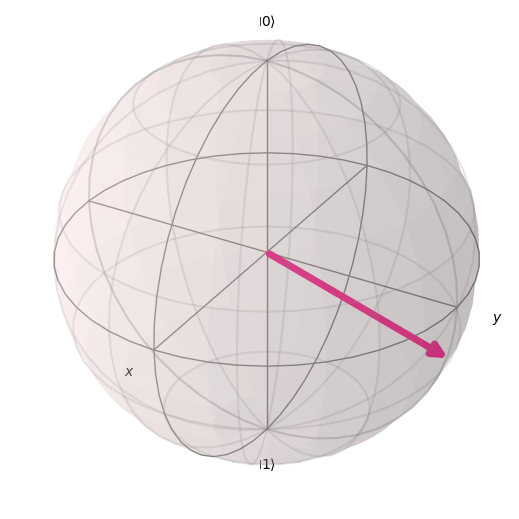

In [ ]:
n = approximate_depth(TARGET, EPSILON)
print(f"Aproksimācijas dziļums priekš kļūdas {EPSILON}: {n}")

final_circuit = solovay_kitaev_decomposition(TARGET, 2)

T_su2, phase = remove_global_phase(TARGET)
print("TARGET bez globālās fāzes:")
print(T_su2)
print()

final_operator = Operator(final_circuit).data
print("Final circuit operator:")
print(final_operator)
print("Ar pievienoto globālo fāzi:")
final_operator_with_phase = add_global_phase(final_operator, phase)
print(final_operator_with_phase)

print("Final approximation error:", compare_su2(TARGET, final_operator))

final_circuit.draw()

# state = 1 / np.sqrt(2) * np.array([1, 1])
# new_state = final_operator @ state
# theta = np.arccos(np.real(new_state[0])) * 2
# phase = np.angle(new_state[1] / np.sin(theta / 2))
# vector = np.array([
#     np.sin(theta) * np.cos(phase),
#     np.sin(theta) * np.sin(phase),
#     np.cos(theta)
# ])
# plot_bloch_vector(vector.flatten())